# Image Segmentation Using  U-Net

## 1-U-Net
U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg.

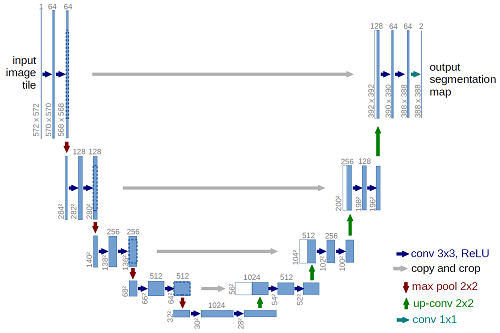
> architecture (example for 32x32 pixels in the lowest resolution).

## 2-Import Libraries

In [1]:
import os
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

## 3-loading Image Dataset

In [2]:
input_dir = "oxford-pets/images/images"
target_dir = "oxford-pets/annotations/annotations/trimaps"
img_size = (160, 160)
num_classes = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

Number of samples: 7390


## 4-Display sample of Image Dataset

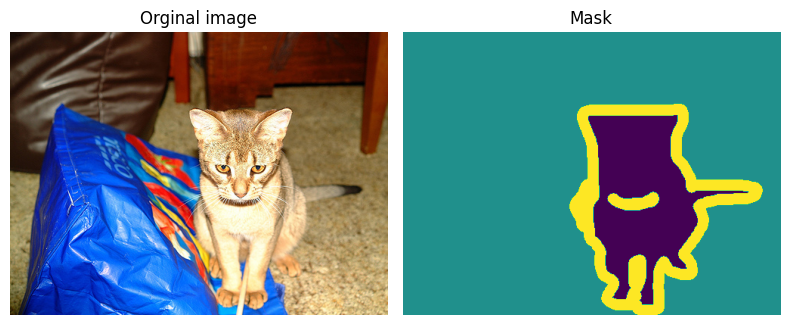

In [3]:
# Display image #7
i = 7
figure, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,8))
ax.ravel()[0].imshow(mpimg.imread(input_img_paths[i]))
ax.ravel()[0].set_title("Orginal image")
ax.ravel()[0].set_axis_off()
ax.ravel()[1].imshow(mpimg.imread(target_img_paths[i]))
ax.ravel()[1].set_title("Mask")
ax.ravel()[1].set_axis_off()
#ax.ravel()[2].imshow(PIL.ImageOps.autocontrast(load_img(target_img_paths[i])))
#ax.ravel()[2].set_title("Contrast of mask")
#ax.ravel()[2].set_axis_off()
plt.tight_layout()

## 5-Pets Dataset

In [4]:
class PetsDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

## 6-Build the U-Net Model Architecture

In [5]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## 7-Split Dataset into a training and a validation set

In [6]:
val_samples = 1108 # 85% Training -- 15% Validation
random.Random(1822).shuffle(input_img_paths)
random.Random(1822).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = PetsDataset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = PetsDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 8-Training

In [7]:
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("pets_segmentation.keras", save_best_only=True)
]

epochs = 30
modelunet=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30


/Users/xingruizhu/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


392/392 ━━━━━━━━━━━━━━━━━━━━ 261s 656ms/step - accuracy: 0.6712 - loss: 1.4514 - val_accuracy: 0.5869 - val_loss: 2.8344
Epoch 2/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 255s 650ms/step - accuracy: 0.8112 - loss: 0.4763 - val_accuracy: 0.8333 - val_loss: 0.4193
Epoch 3/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 256s 651ms/step - accuracy: 0.8384 - loss: 0.4077 - val_accuracy: 0.8344 - val_loss: 0.4191
Epoch 4/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 254s 647ms/step - accuracy: 0.8529 - loss: 0.3751 - val_accuracy: 0.8530 - val_loss: 0.3754
Epoch 5/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 254s 646ms/step - accuracy: 0.8684 - loss: 0.3340 - val_accuracy: 0.8550 - val_loss: 0.3699
Epoch 6/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 254s 647ms/step - accuracy: 0.8786 - loss: 0.3062 - val_accuracy: 0.8430 - val_loss: 0.4021
Epoch 7/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 254s 646ms/step - accuracy: 0.8878 - loss: 0.2831 - val_accuracy: 0.8622 - val_loss: 0.3550
Epoch 8/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 255s 650ms/step - accuracy: 0.8972 - loss: 0.25

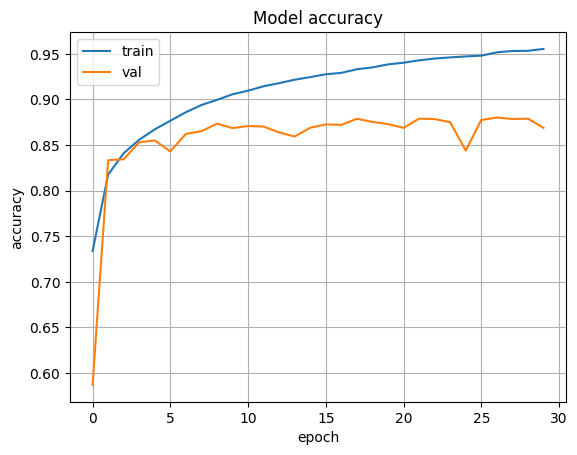

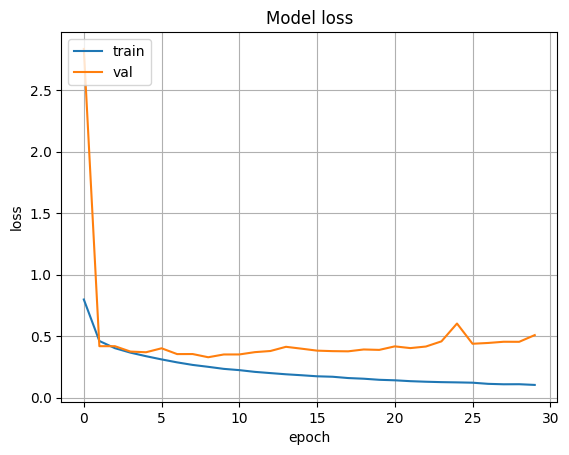

In [8]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(modelunet.history['accuracy'])
plt.plot(modelunet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()
# summarize history for loss
plt.plot(modelunet.history['loss'])
plt.plot(modelunet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()



## 9-Inference

In [9]:
# Generate predictions for all images in the validation set
val_gen = PetsDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step


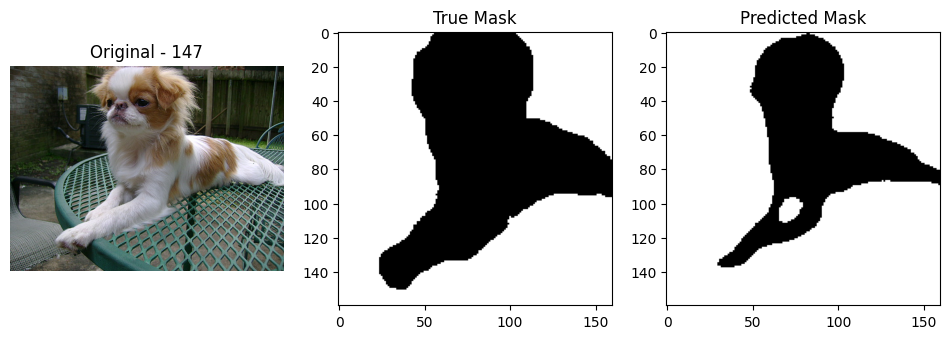

In [56]:
# 仅用于测试目的
test_index = 147  # 可以改成其他索引以检查不同的图像

# 获得真实的掩码
true_mask = load_img(val_target_img_paths[test_index], target_size=img_size, color_mode="grayscale")
true_mask = np.array(true_mask)
true_mask -= 1  # 调整标签

# 将掩码转换为二进制格式
# 如果您的任务是二分类，您可以选择其中一个类别作为前景
# 1:前景; 2: 背景; 3: 轮廓

true_mask = true_mask == 1  # 例如，假设类别1是我们感兴趣的前景

# 获得预测的掩码
pred_mask = np.argmax(val_preds[test_index], axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)
pred_mask = pred_mask.astype(bool)

# 显示掩码
import matplotlib.pyplot as plt

# 显示原始图像
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(mpimg.imread(val_input_img_paths[test_index]))
plt.title(f"Original - {test_index}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask[..., 0], cmap='gray')  # 确保这里是二维数组
plt.title('Predicted Mask')
plt.show()


In [30]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice_score = 2 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score

# 计算IoU和Dice系数
iou_scores = []
dice_scores = []

for i in range(len(val_preds)):  # 使用val_preds的长度
    # 获得真实的掩码
    true_mask = load_img(val_target_img_paths[i], target_size=img_size, color_mode="grayscale")
    true_mask = np.array(true_mask)
    true_mask -= 1  # 调整标签

    # 将掩码转换为二进制格式
    # 如果您的任务是二分类，您可以选择其中一个类别作为前景
    true_mask = true_mask == 1  # 例如，假设类别1是我们感兴趣的前景

    # 获得预测的掩码
    pred_mask = np.argmax(val_preds[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask.astype(bool)

    # 计算IoU和Dice
    iou = calculate_iou(true_mask, pred_mask)
    dice = calculate_dice(true_mask, pred_mask)

    iou_scores.append(iou)
    dice_scores.append(dice)

# 计算平均IoU和Dice系数
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)

print("平均 IoU 分数:", mean_iou)
print("平均 Dice 分数:", mean_dice)


平均 IoU 分数: 0.5401585643269101
平均 Dice 分数: 109.36945390288174


## 10-Display results for validation image

In [31]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

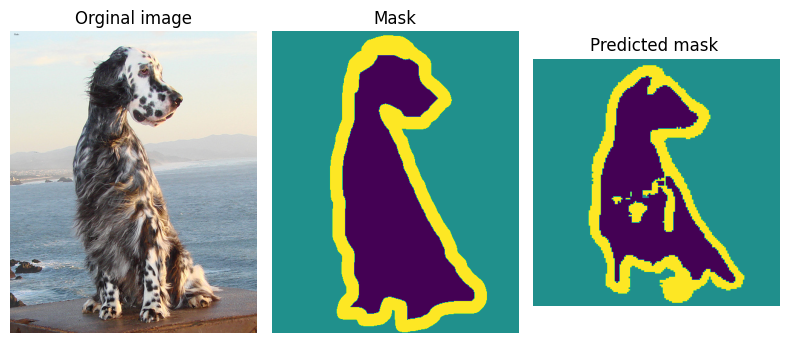

In [32]:
# Display image #120
i = 120
figure, ax = plt.subplots(nrows=1,ncols=3,figsize=(8,5))
ax.ravel()[0].imshow(mpimg.imread(val_input_img_paths[i]))
ax.ravel()[0].set_title("Orginal image")
ax.ravel()[0].set_axis_off()
ax.ravel()[1].imshow(mpimg.imread(val_target_img_paths[i]))
ax.ravel()[1].set_title("Mask")
ax.ravel()[1].set_axis_off()
ax.ravel()[2].imshow(display_mask(i))
ax.ravel()[2].set_title("Predicted mask ")
ax.ravel()[2].set_axis_off()
plt.tight_layout()

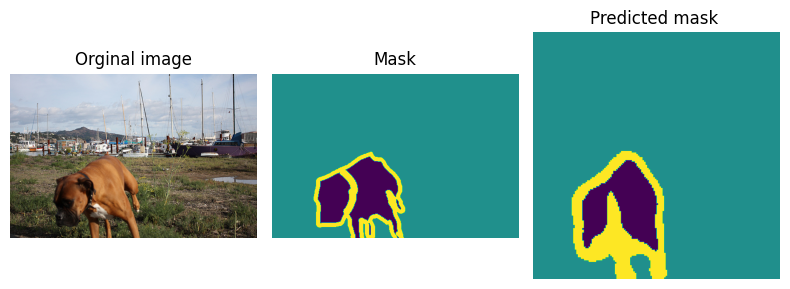

In [33]:
# Display image #180
i = 180
figure, ax = plt.subplots(nrows=1,ncols=3,figsize=(8,5))
ax.ravel()[0].imshow(mpimg.imread(val_input_img_paths[i]))
ax.ravel()[0].set_title("Orginal image")
ax.ravel()[0].set_axis_off()
ax.ravel()[1].imshow(mpimg.imread(val_target_img_paths[i]))
ax.ravel()[1].set_title("Mask")
ax.ravel()[1].set_axis_off()
ax.ravel()[2].imshow(display_mask(i))
ax.ravel()[2].set_title("Predicted mask ")
ax.ravel()[2].set_axis_off()
plt.tight_layout()

## 11- References

1. https://en.wikipedia.org/wiki/U-Net

1. https://keras.io/examples/vision/oxford_pets_image_segmentation/

1. https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/